In [1]:
import copy
import numpy as np
import palettable

In [2]:
import linefinder.analyze_data.worldlines as worldlines
import linefinder.analyze_data.plot_worldlines as plot_worldlines

In [3]:
import galaxy_dive.plot_data.plotting as plotting

In [4]:
import verdict

# Load the Data

In [5]:
w = worldlines.Worldlines(
    data_dir = '/scratch/03057/zhafen/linefinder_data/multiphysics/m12i_res7100_mhdcv/data',
    tag = 'm12imhdcv_galaxy',
    halo_data_dir = '/scratch/03057/zhafen/halo_files/multiphysics/m12i_res7100_mhdcv',
    main_halo_id = 0,
)

In [6]:
w_plotter = plot_worldlines.WorldlinesPlotter( w, )

In [7]:
# We'll explore classifications relative to this snapshot
snum = 600
ind = snum - 600

# Analyze

### Classify as ex-situ

In [8]:
w.data_masker.clear_masks( True )

In [9]:
star_formation_event = np.zeros( w.base_data_shape ).astype( int )
star_formation_event[:,:-1] = w.get_event_id( w.get_data( 'PType' ) == 4 )

In [10]:
mt_gal_id_at_formation = w.get_data( 'mt_gal_id' )[star_formation_event == 1]

In [11]:
is_ex_situ = ( mt_gal_id_at_formation != w.main_halo_id )

In [12]:
is_ex_situ_tiled = np.invert( np.tile( is_ex_situ, (w.n_snaps, 1 ) ).transpose() )

In [13]:
w.data_masker.mask_data( 'is_ex_situ', mask_name='is_ex_situ', optional_mask=True, custom_mask=is_ex_situ_tiled )

### Ex-situ vs time

In [14]:
star_in_gal = w.get_data( 'is_in_main_gal' ) & ( w.get_data( 'PType' ) == 4 )

In [15]:
# Select stars in the main galaxy
w.mask_data( 'is_in_main_gal', data_value=True )
w.mask_data( 'PType', data_value=4 )

In [16]:
tracked_mass_in_gal = w.get_selected_data( 'M', compress=False ).sum( axis=0 )

In [17]:
tracked_ex_situ_mass_in_gal = w.get_selected_data( 'M', compress=False, optional_masks=[ 'is_ex_situ' ] ).sum( axis=0 )

In [18]:
frac_ex_situ = tracked_ex_situ_mass_in_gal / tracked_mass_in_gal

In [19]:
m_ex_situ = frac_ex_situ * w.get_data( 'M_star' )[0,:]

# Plot

Text(0, 0.5, '$f_{\\star, {\\rm ex}}$')

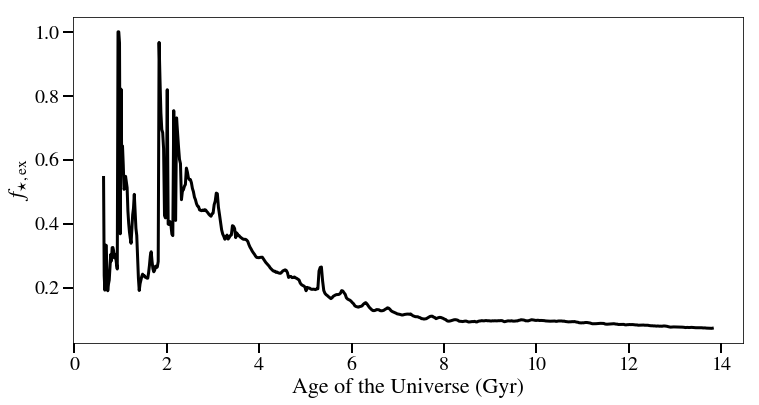

In [20]:
%matplotlib inline

fig = plt.figure( figsize=(12, 6), facecolor='w' )
ax = plt.gca()

ax.plot(
    w.get_data( 'time' ),
    frac_ex_situ,
    linewidth = 3,
    color = 'k',
)

ax.set_xlabel( 'Age of the Universe (Gyr)', fontsize=22 )
ax.set_ylabel( r'$f_{\star, {\rm ex}}$', fontsize=22 )

Text(0, 0.5, '$M_{\\star, {\\rm ex}}$ ($M_\\odot$)')

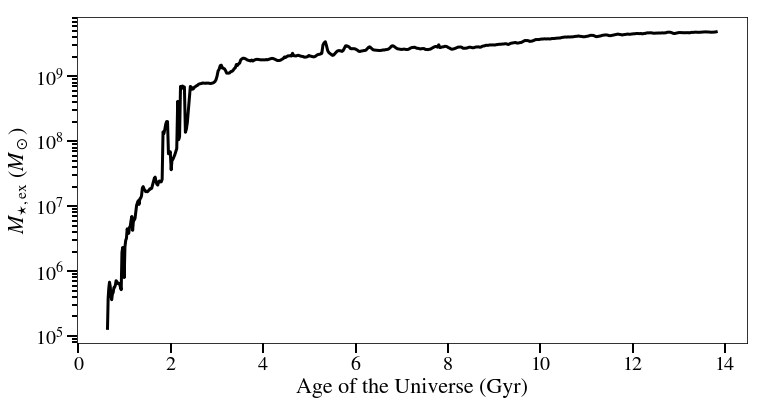

In [24]:
%matplotlib inline

fig = plt.figure( figsize=(12, 6), facecolor='w' )
ax = plt.gca()

ax.plot(
    w.get_data( 'time' ),
    m_ex_situ,
    linewidth = 3,
    color = 'k',
)
ax.set_yscale( 'log' )

ax.set_xlabel( 'Age of the Universe (Gyr)', fontsize=22 )
ax.set_ylabel( r'$M_{\star, {\rm ex}}$ ($M_\odot$)', fontsize=22 )

In [22]:
data = verdict.Dict( {
    'redshift': w.get_data( 'redshift' ),
    'age of universe': w.get_data( 'time' ),
    'f_ex_situ': frac_ex_situ,
    'M_ex_situe': m_ex_situ,
} )

In [23]:
data.to_hdf5( './data/merger_history.h5' )